__1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.__

In [1]:
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns

from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

In [2]:
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])
data_w = data.copy().resample('W').mean()
data_w.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,3.517483,1.0,3.517483,1.0,3.517483,11.58042,0.160839,0.000000,0.167832
2002-01-13,31487.386905,2002.0,1.000000,10.000000,1.0,10.000000,2.0,3.000000,11.50000,0.000000,0.000000,0.000000
2002-01-20,31452.880952,2002.0,1.000000,17.000000,1.0,17.000000,3.0,3.000000,11.50000,0.000000,0.142857,0.000000
2002-01-27,30141.529762,2002.0,1.000000,24.000000,1.0,24.000000,4.0,3.000000,11.50000,0.142857,0.000000,0.142857
2002-02-03,29196.488095,2002.0,1.428571,17.714286,1.0,31.000000,5.0,3.000000,11.50000,0.000000,0.000000,0.000000


In [3]:
# Удалим данные которые потеряли актуальность:
data_w.drop('hour', axis=1,inplace=True)
data_w.drop('dayofweek', axis=1,inplace=True)
data_w.drop('dayofmonth', axis=1,inplace=True)
data_w.drop('dayofyear', axis=1,inplace=True)
# Поскольку в годовом развороте ряда тренда нет (временные ряды 2 и 3), признак 'year' исключим:
data_w.drop('year', axis=1,inplace=True)
data_w.head()

,PJME_MW,month,quarter,weekofyear,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,
2002-01-06,32392.160839,1.000000,1.0,1.0,0.160839,0.000000,0.167832
2002-01-13,31487.386905,1.000000,1.0,2.0,0.000000,0.000000,0.000000
2002-01-20,31452.880952,1.000000,1.0,3.0,0.000000,0.142857,0.000000
2002-01-27,30141.529762,1.000000,1.0,4.0,0.142857,0.000000,0.142857
2002-02-03,29196.488095,1.428571,1.0,5.0,0.000000,0.000000,0.000000


__2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .__

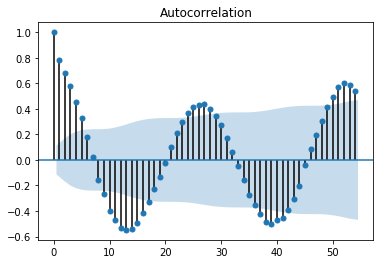

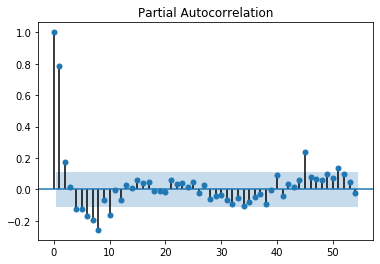

In [4]:
sm.graphics.tsa.plot_acf(data_w['PJME_MW'].values[:300], lags=54)
plt.show()
sm.graphics.tsa.plot_pacf(data_w['PJME_MW'].values[:300], lags=54)
plt.show()

In [5]:
N1 = 300   # берем дданные не от начала, быстрее работает
N2 = 4     # число точек для теста
h = 4
nforecast = N2 + h

mod = sm.tsa.statespace.SARIMAX(data_w['PJME_MW'].values[N1:-N2],order=[1,1,2],
                                seasonal_order=[0,1,2,52] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt = mod.fit()
print('AIC:{}',results_opt.aic)

AIC:{} 7383.994911040063


In [6]:
results_opt.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.6664,0.142,4.705,0.000,0.389,0.944
ma.L1,-1.2993,0.183,-7.082,0.000,-1.659,-0.940
ma.L2,0.3043,0.171,1.780,0.075,-0.031,0.639
ma.S.L52,-0.7478,0.075,-9.940,0.000,-0.895,-0.600
ma.S.L104,-0.0165,0.069,-0.239,0.811,-0.152,0.119
sigma2,7.972e+06,3.01e-08,2.64e+14,0.000,7.97e+06,7.97e+06


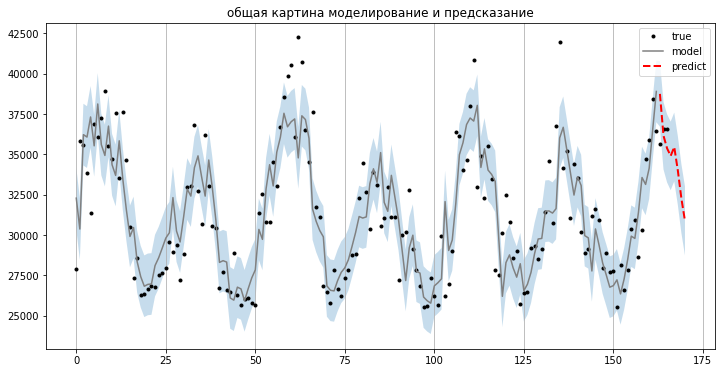

In [7]:
N3 = 400  # отступ данных для отображения  модели (для улучшения визуальных качеств рисунка - берем из интервала [0-500])
predict_ = results_opt.get_prediction(end=results_opt.nobs + nforecast)  # делаем предсказание

# отображаем
idx = np.arange(len(predict_.predicted_mean) - N3)
predict_ci = predict_.conf_int(alpha = 0.5)

#
fig, ax = plt.subplots(figsize=(12,6))
ax.xaxis.grid()
ax.plot(data_w['PJME_MW'].values[N3+N1:], 'k.',label='true')

# 
ax.plot(idx[:-nforecast], predict_.predicted_mean[N3:-nforecast], 'gray',label = 'model')
ax.plot(idx[-nforecast:], predict_.predicted_mean[-nforecast:], 'r--', linestyle='--', linewidth=2, label='predict')
ax.fill_between(idx, predict_ci[N3:, 0], predict_ci[N3:, 1], alpha=0.25)
plt.legend()
ax.set(title='общая картина моделирование и предсказание');

__3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.__

In [8]:
N2 = 1  # число точек для теста
h = 1
nforecast = N2+h

mod = sm.tsa.statespace.SARIMAX(data_w['PJME_MW'].values[N1:-N2],order=[1,1,2],
                                seasonal_order=[0,1,2,52] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt = mod.fit()
print('AIC:{}',results_opt.aic)

AIC:{} 7440.503439502465


In [9]:
results_opt.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.6652,0.143,4.650,0.000,0.385,0.946
ma.L1,-1.2996,0.186,-7.004,0.000,-1.663,-0.936
ma.L2,0.3045,0.173,1.762,0.078,-0.034,0.643
ma.S.L52,-0.7579,0.076,-9.999,0.000,-0.906,-0.609
ma.S.L104,-0.0082,0.070,-0.118,0.906,-0.145,0.128
sigma2,8.044e+06,3.04e-08,2.64e+14,0.000,8.04e+06,8.04e+06


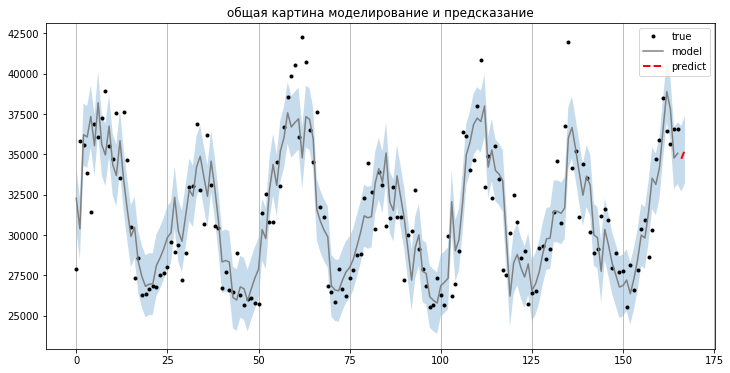

In [10]:
N3=400  # отступ данных для отображения  модели (для улучшения визуальных качеств рисунка - берем из интервала [0-500])
predict_ = results_opt.get_prediction(end=results_opt.nobs + nforecast)  # делаем предсказание

# отображаем
idx = np.arange(len(predict_.predicted_mean)-N3)
predict_ci = predict_.conf_int(alpha=0.5)

#
fig, ax = plt.subplots(figsize=(12,6))
ax.xaxis.grid()
ax.plot(data_w['PJME_MW'].values[N3+N1:], 'k.',label='true')

# 
ax.plot(idx[:-nforecast], predict_.predicted_mean[N3:-nforecast], 'gray',label = 'model')
ax.plot(idx[-nforecast:], predict_.predicted_mean[-nforecast:], 'r--', linestyle='--', linewidth=2, label='predict')
ax.fill_between(idx, predict_ci[N3:, 0], predict_ci[N3:, 1], alpha=0.25)
plt.legend()
ax.set(title='общая картина моделирование и предсказание');

__4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.__

In [11]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE 
import seaborn as sns

scl = StandardScaler()
tsne_ = TSNE(n_components=2)

X = data_w.iloc[:,:-1].values

Xscale = scl.fit_transform(X)
X_t = tsne_.fit_transform(Xscale)

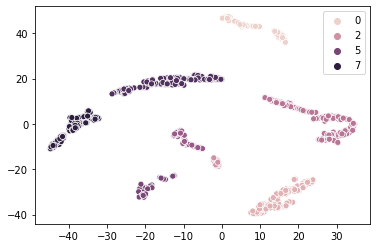

In [12]:
clast_0 = DBSCAN(eps=5, leaf_size=15 )
clast_1 = DBSCAN(eps=2, leaf_size=5)
X_clast =clast_0.fit_predict(X_t)
X_scale_clast =clast_1.fit_predict(Xscale)

sns.scatterplot(X_t[:,0],X_t[:,1], hue=X_clast)
plt.show()

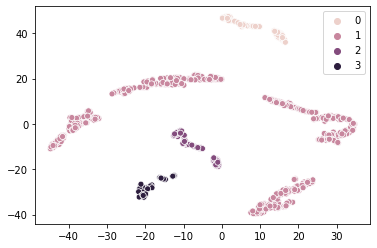

In [13]:
sns.scatterplot(X_t[:,0],X_t[:,1], hue=X_scale_clast )
plt.show()

In [14]:
print('Число кластеров в календаре с масштабированием: ',len(np.unique(X_scale_clast)))
print('Число кластеров в календаре: ',len(np.unique(X_clast)))

Число кластеров в календаре с масштабированием:  4
Число кластеров в календаре:  8


In [15]:
data_w['week_month'] = X_clast
data_w.iloc[np.where(data_w['week_month']==0)[0]].iloc[:10,:]

,PJME_MW,month,quarter,weekofyear,is_holiday,is_prev_holiday,is_next_holiday,week_month
Date,,,,,,,,
2002-01-06,32392.160839,1.000000,1.0,1.0,0.160839,0.0,0.167832,0
2002-01-27,30141.529762,1.000000,1.0,4.0,0.142857,0.0,0.142857,0
2002-02-24,29144.130952,2.000000,1.0,8.0,0.142857,0.0,0.142857,0
2002-06-02,31448.660714,5.285714,2.0,22.0,0.142857,0.0,0.142857,0
2002-09-08,31535.172619,9.000000,3.0,36.0,0.142857,0.0,0.142857,0
2002-10-20,27504.827381,10.000000,4.0,42.0,0.142857,0.0,0.142857,0
2002-11-17,28881.886905,11.000000,4.0,46.0,0.142857,0.0,0.142857,0
2003-01-26,37169.547619,1.000000,1.0,4.0,0.142857,0.0,0.142857,0
2003-02-23,33023.458333,2.000000,1.0,8.0,0.142857,0.0,0.142857,0


In [16]:
data_w.iloc[np.where(data_w['week_month']==2)[0]].iloc[:10,:]

,PJME_MW,month,quarter,weekofyear,is_holiday,is_prev_holiday,is_next_holiday,week_month
Date,,,,,,,,
2002-01-20,31452.880952,1.0,1.0,3.0,0.0,0.142857,0.0,2
2002-02-17,30616.565476,2.0,1.0,7.0,0.0,0.142857,0.0,2
2003-01-19,35999.547619,1.0,1.0,3.0,0.0,0.142857,0.0,2
2003-02-16,35533.589286,2.0,1.0,7.0,0.0,0.142857,0.0,2
2004-01-18,36814.470238,1.0,1.0,3.0,0.0,0.142857,0.0,2
2004-02-15,33151.982143,2.0,1.0,7.0,0.0,0.142857,0.0,2
2005-01-16,32488.148810,1.0,1.0,2.0,0.0,0.142857,0.0,2
2005-02-20,33284.934524,2.0,1.0,7.0,0.0,0.142857,0.0,2
2006-01-15,31858.672619,1.0,1.0,2.0,0.0,0.142857,0.0,2


In [17]:
from sklearn.decomposition import PCA

pca  = PCA(n_components = 2, svd_solver = 'full')
Xpca = pca.fit_transform(Xscale[:,1:])
Xpca.shape

(866, 2)

In [18]:
data_w['pca1'] = Xpca[:,0]
data_w['pca2'] = Xpca[:,1]

In [19]:
first_diff = np.array(data_w.iloc[1:,0].values - data_w.iloc[:-1,0].values).astype('float32') 
data_w['diff1'] = 0.0
data_w['diff1'] =  data_w['diff1'].astype('float') 
data_w['diff1'].values[1:] = first_diff

In [20]:
first_diff_d = (first_diff) / data_w.iloc[1:,0].values
data_w['diff1_d'] = 0.0
data_w['diff1_d'] =  data_w['diff1_d'].astype('float') 
data_w['diff1_d'].values[1:] = np.array(first_diff_d).astype('float32')

In [21]:
first_diff_l = np.log(data_w.iloc[1:,0].values)
data_w['diff1_l'] = 0
data_w['diff1_l'] =  data_w['diff1_l'].astype('float') 
data_w['diff1_l'].values[1:] = first_diff_l

In [22]:
# Добавим скользящее среднее с глубиной 52 недели. Размер окна определен длиной годовых циклов.
data_w['w52'] = data_w['PJME_MW'].rolling(window=52).mean()

In [23]:
#Добавим еще и экспонентциальную среднюю.
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

data_w['exp_0_05'] = exponential_smoothing(data_w['PJME_MW'], 0.05)

In [24]:
#В итоге данные примут вид
data_w.iloc[10:15,:]

,PJME_MW,month,quarter,weekofyear,is_holiday,is_prev_holiday,is_next_holiday,week_month,pca1,pca2,diff1,diff1_d,diff1_l,w52,exp_0_05
Date,,,,,,,,,,,,,,,
2002-03-17,28672.779762,3.0,1.0,11.0,0.0,0.0,0.0,1,-2.037281,-0.353362,-768.130981,-0.026790,10.263704,NaN,31436.852496
2002-03-24,29927.488095,3.0,1.0,12.0,0.0,0.0,0.0,1,-1.999420,-0.360328,1254.708374,0.041925,10.306533,NaN,31361.384276
2002-03-31,27595.869048,3.0,1.0,13.0,0.0,0.0,0.0,1,-1.961559,-0.367293,-2331.619141,-0.084492,10.225421,NaN,31173.108514
2002-04-07,28308.778443,4.0,2.0,14.0,0.0,0.0,0.0,3,-1.237759,-0.479240,712.909424,0.025183,10.250927,NaN,31029.892011
2002-04-14,27182.482143,4.0,2.0,15.0,0.0,0.0,0.0,3,-1.199898,-0.486205,-1126.296265,-0.041435,10.210328,NaN,30837.521517


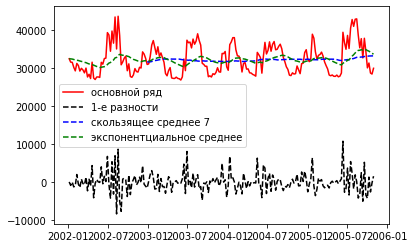

In [25]:
N100 = 200
plt.plot(data_w.index[:N100],data_w['PJME_MW'][:N100],'r',label ='основной ряд')
plt.plot(data_w.index[:N100],data_w['diff1'][:N100],'--k',label ='1-е разности')
plt.plot(data_w.index[:N100],data_w['w52'][:N100],'--b',label ='скользящее среднее 7')
plt.plot(data_w.index[:N100],data_w['exp_0_05'][:N100],'--g',label ='экспонентциальное среднее')
plt.legend()
plt.show()

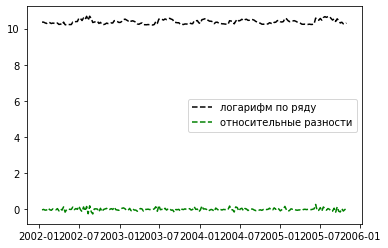

In [26]:
N100 = 200
plt.plot(data_w.index[1:N100],data_w['diff1_l'][1:N100],'--k',label ='логарифм по ряду')

plt.plot(data_w.index[1:N100],data_w['diff1_d'][1:N100],'--g',label ='относительные разности')
plt.legend()
plt.show()

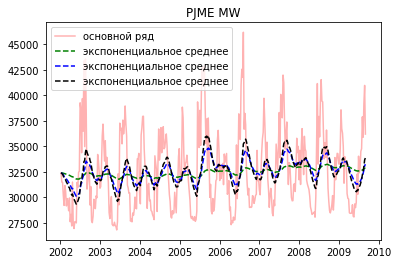

In [27]:
data_w['exp_0_01'] = exponential_smoothing(data_w['PJME_MW'], 0.01)
data_w['exp_0_03'] = exponential_smoothing(data_w['PJME_MW'], 0.03)
data_w['exp_0_04'] = exponential_smoothing(data_w['PJME_MW'], 0.04)
data_w['exp_0_06'] = exponential_smoothing(data_w['PJME_MW'], 0.06)
data_w['exp_0_07'] = exponential_smoothing(data_w['PJME_MW'], 0.07)
data_w['exp_0_08'] = exponential_smoothing(data_w['PJME_MW'], 0.08)

N100 = 400
plt.plot(data_w.index[:N100],data_w['PJME_MW'][:N100],'r',label ='основной ряд',alpha=0.3)
plt.plot(data_w.index[:N100],data_w['exp_0_01'][:N100],'--g',label ='экспоненциальное среднее')
plt.plot(data_w.index[:N100],data_w['exp_0_05'][:N100],'--b',label ='экспоненциальное среднее')
plt.plot(data_w.index[:N100],data_w['exp_0_08'][:N100],'--k',label ='экспоненциальное среднее')
plt.legend()
plt.title('PJME MW')
plt.show()

In [28]:
# Добавим истории длиной p в признаках автокорреляции - два месяца
p = 9
for i in range(p):
    data_w['t'+str(p-i)]=0
    data_w['t'+str(p-i)].values[p:] = data_w['PJME_MW'].values[i:-(p)+i]

In [29]:
# Аналогично добавляем первые разности на глубину p
for i in range(p):
    data_w['d'+str(p-i)]=0
    data_w['d'+str(p-i)].values[p:] = data_w['diff1'].values[i:-(p)+i]

In [30]:
# Итого
data_w.head()

,PJME_MW,month,quarter,weekofyear,is_holiday,is_prev_holiday,is_next_holiday,week_month,pca1,pca2,...,t1,d9,d8,d7,d6,d5,d4,d3,d2,d1
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-06,32392.160839,1.000000,1.0,1.0,0.160839,0.000000,0.167832,0,-2.454252,1.805922,...,0,0,0,0,0,0,0,0,0,0
2002-01-13,31487.386905,1.000000,1.0,2.0,0.000000,0.000000,0.000000,1,-2.716066,-0.229153,...,0,0,0,0,0,0,0,0,0,0
2002-01-20,31452.880952,1.000000,1.0,3.0,0.000000,0.142857,0.000000,2,-2.339530,1.514252,...,0,0,0,0,0,0,0,0,0,0
2002-01-27,30141.529762,1.000000,1.0,4.0,0.142857,0.000000,0.142857,0,-2.374173,1.558280,...,0,0,0,0,0,0,0,0,0,0
2002-02-03,29196.488095,1.428571,1.0,5.0,0.000000,0.000000,0.000000,1,-2.530047,-0.263232,...,0,0,0,0,0,0,0,0,0,0


Запишем итоговую систему признаков и проведем ее анализ. Горизонт прогнозирования h = 4, тогда target = y(t+h) = y(t+4)

In [31]:
scl_target = StandardScaler() 
# p = 9
h = 4
target = data_w['PJME_MW'].values[h+p:].reshape((data_w.shape[0]-h-p,1))
y = scl_target.fit_transform(target)
y.shape

(853, 1)

Входной набор признаков берем из нашей таблицы. Необходимо помнить, что у нас есть интегральные признаки (для календаря), которые связаны с базовыми признаками. Обычно такие признаки рассматривают отдельно. Однако для эксперимента оставим все признаки для процедуры селекции.

In [32]:
scl_x = StandardScaler() 

X = data_w.iloc[p:-h,:].values
X = scl_x.fit_transform(X.astype('float'))
X.shape

(853, 39)

In [33]:
np.isnan(X).sum()

42

In [34]:
X = np.nan_to_num(X)
np.isnan(X).sum()

0

Размеры выборок по строкам совпали. Мы взяли на h строк меньше для Х и на h значений позднее по target. Таким образом, входной набор данных сформирован.

In [35]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import f_regression, mutual_info_regression

f_test, _ = f_regression(X, y.ravel())
f_test /= np.max(f_test)
for i in range(X.shape[1]):
    print("F-test={:.2f},  I={}".format(f_test[i],i))

F-test=0.54,  I=0
F-test=0.01,  I=1
F-test=0.01,  I=2
F-test=0.01,  I=3
F-test=0.04,  I=4
F-test=0.03,  I=5
F-test=0.04,  I=6
F-test=0.03,  I=7
F-test=0.02,  I=8
F-test=0.05,  I=9
F-test=0.10,  I=10
F-test=0.10,  I=11
F-test=0.55,  I=12
F-test=0.02,  I=13
F-test=0.07,  I=14
F-test=0.00,  I=15
F-test=0.05,  I=16
F-test=0.06,  I=17
F-test=0.07,  I=18
F-test=0.07,  I=19
F-test=0.06,  I=20
F-test=1.00,  I=21
F-test=0.94,  I=22
F-test=0.66,  I=23
F-test=0.43,  I=24
F-test=0.20,  I=25
F-test=0.05,  I=26
F-test=0.00,  I=27
F-test=0.06,  I=28
F-test=0.23,  I=29
F-test=0.00,  I=30
F-test=0.00,  I=31
F-test=0.02,  I=32
F-test=0.03,  I=33
F-test=0.07,  I=34
F-test=0.11,  I=35
F-test=0.13,  I=36
F-test=0.14,  I=37
F-test=0.12,  I=38


In [36]:
sfk = SelectKBest(f_regression, k = 5)
X_new1 = sfk.fit_transform(X, y.ravel())
X_new1.shape

(853, 5)

In [37]:
column_names = data_w.columns[sfk.get_support()]
column_names

Index(['PJME_MW', 'diff1_l', 't9', 't8', 't7'], dtype='object')

In [38]:
#Лучшее множество признаков отделено в X_new1. Проверим результат оценки признаков по процентному отбору и сохраним его в X_new2.
sfp = SelectPercentile(f_regression, percentile = 10)
X_new2 = sfp.fit_transform(X, y.ravel())
X_new2.shape

(853, 4)

In [39]:
column_namesp = data_w.columns[sfp.get_support()]
column_namesp

Index(['diff1_l', 't9', 't8', 't7'], dtype='object')

Наконец, третий вариант - применим выделение признаков через построение модели. Помним, что модель должна уметь выбрать подмножество признаков или вернуть коэффициент их влиятельности. Это ограничивает выбор моделей. Возьмем как оценшик GradientBoostingRegressor и построим новое пространство в X_new3

In [40]:
gr_model = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=100).fit(X, y.ravel())
sfm = SelectFromModel(gr_model,  max_features = 5)

sfm.fit(X, y.ravel())
X_new3 = sfm.transform(X)
X_new3.shape

(853, 5)

In [41]:
list_param_k =np.where(sfk.get_support())[0]
list_param_p =np.where(sfp.get_support())[0]
list_param_m =np.where(sfm.get_support())[0]

print('Номера признаков k лучших признаков : ',list_param_k)
print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
print('Номера признаков для выбора по модели : ',list_param_m)

Номера признаков k лучших признаков :  [ 0 12 21 22 23]
Номера признаков лучших признаков по процентной форме:  [12 21 22 23]
Номера признаков для выбора по модели :  [ 1  3  8 21 22]


Пересечение выбора по отбору для модели и по количественным оценкам связи в признаках 21, 22. Имеет смысл брать объединение выборов. Возьмем [0, 3, 8, 12, 21, 22, 23] признаки и перейдем к построению модели.

In [42]:
list_par=[0, 3, 8, 12, 21, 22, 23]
X_new = X[:,list_par]
data_w.columns[list_par]

Index(['PJME_MW', 'weekofyear', 'pca1', 'diff1_l', 't9', 't8', 't7'], dtype='object')

In [43]:
# сделаем функцию
def split_data( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

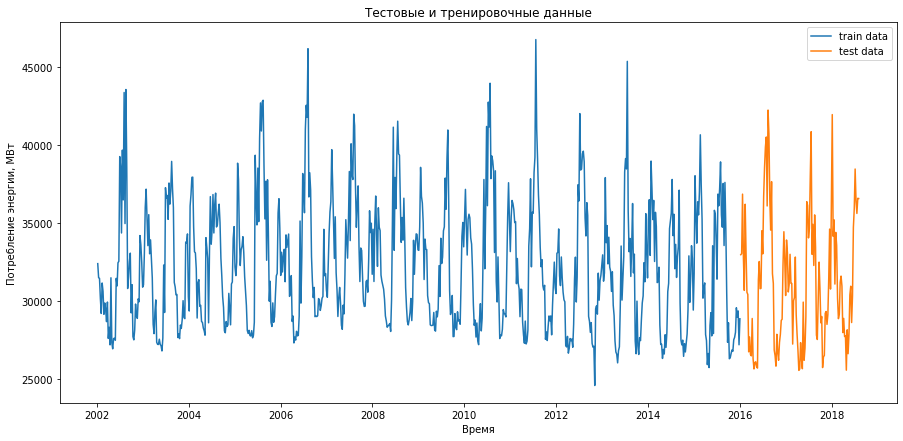

In [44]:
train, test = split_data( data_w, '01-06-2016')

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index.get_level_values('Date'),train['PJME_MW'], label='train data' )
plt.plot(test.index.get_level_values('Date'),test['PJME_MW'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [45]:
X_train = X_new[:train.shape[0],:]
y_train = y[:train.shape[0],0]
X_test = X_new[train.shape[0]:,:]
y_test = y[train.shape[0]:,0]

In [46]:
from sklearn.ensemble import GradientBoostingRegressor

In [47]:
# Строим модель. Все модели возьмем в варианте параметров по умолчанию, кроме глубины деревьев.
model_g = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)

In [48]:
model_g.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=5, random_state=0)

In [49]:
# Посмотрим тесты
y_test_pred_g = model_g.predict(X_test)

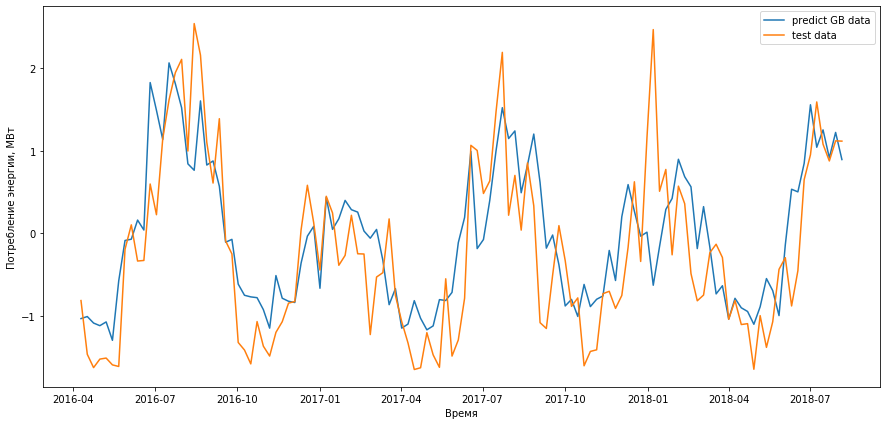

In [50]:
plt.figure( figsize=( 15, 7 ))

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h+p:],y_test_pred_g, label='predict GB data' )
plt.plot(test.index[h+p:],y_test, label='test data')

plt.legend()
plt.show()

In [51]:
# Оценки для сравнения моделей
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   0.4560946869404234 
ошибка mae  :   0.512972075146945 
оценка R2 :   0.5746300846365906


In [52]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   6.652845907087094 %


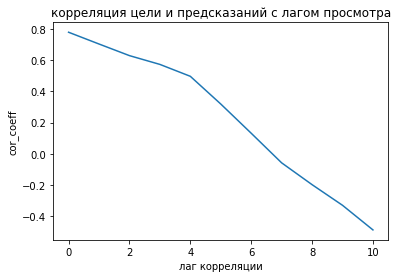

In [53]:
lag=10
p_cor=[np.corrcoef(y_test, y_test_pred_g)[1,0]]
for i in range(lag):
    c=np.corrcoef( y_test[:-(i+1)], y_test_pred_g[(i+1):])[1,0]
    p_cor.append(c)    

plt.plot(np.array(p_cor) )  
plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')
plt.title('корреляция цели и предсказаний с лагом просмотра')
plt.show()

In [54]:
# Попробуем улучшить
from sklearn.model_selection import RandomizedSearchCV

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

param_dist = {"max_depth": [3, 2,10,14,5], 
              "n_estimators":[100,200,300,400,500, 1000, 1200,1500]}

#  randomized search
n_iter_search = 10

model_gr = GradientBoostingRegressor()

random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=n_iter_search, cv=5, iid=False)

random_search.fit(X_train, y_train)

report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.589 (std: 0.116)
Parameters: {'n_estimators': 300, 'max_depth': 2}

Model with rank: 2
Mean validation score: 0.543 (std: 0.110)
Parameters: {'n_estimators': 500, 'max_depth': 5}

Model with rank: 3
Mean validation score: 0.537 (std: 0.120)
Parameters: {'n_estimators': 1200, 'max_depth': 2}



Выбираем модель с рангом 1. {'n_estimators': 300, 'max_depth': 2} (в одном из запусков RandomizedSearchCV был лучший резльтат) и проведем ее обучение на тренировочном наборе.

In [60]:
model_g_best = GradientBoostingRegressor(max_depth=2, n_estimators=300)
model_g_best.fit(X_train, y_train) 
y_test_pred_g = model_g_best.predict(X_test)

er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')
# значение ошибки стало даже больше

ошибка градиентного бустинга MAPE :   6.772811402983328 %


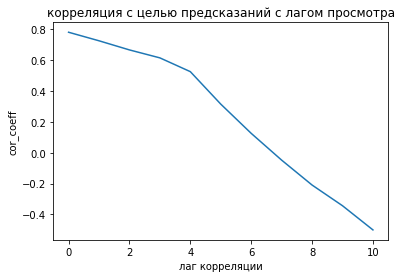

In [61]:
lag=10
p_cor=[np.corrcoef( y_test, y_test_pred_g)[1,0]]
for i in range(lag):
    c=np.corrcoef( y_test[:-(i+1)], y_test_pred_g[(i+1):])[1,0]
    p_cor.append(c)    

plt.plot(np.array(p_cor) )  
plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')
plt.title('корреляция с целью предсказаний с лагом просмотра')
plt.show()
#график почти не изменился

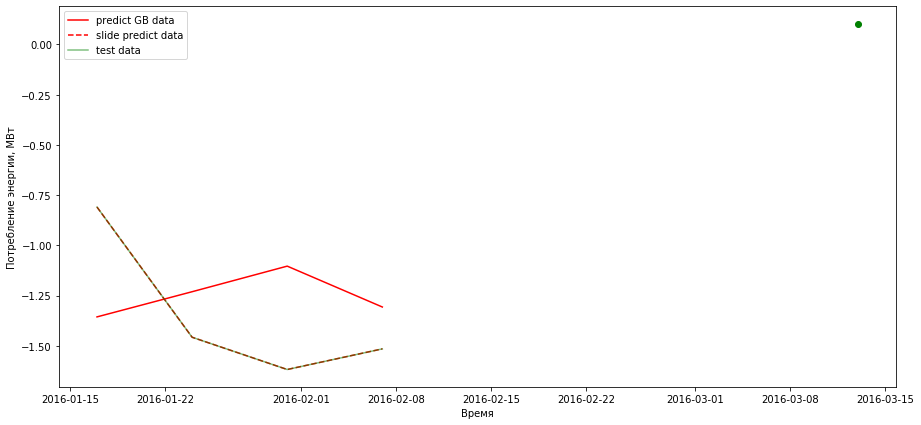

In [62]:
# ['PJME_MW', 'weekofyear', 'pca1', 'diff1_l', 't9', 't8', 't7']
X_test_100 = X_test.copy()
y_test_100 = y_test.copy()
N10 = 4
for i in range(p,N10+p):
    y_test_100[i] = model_g_best.predict(X_test_100[i,:].reshape((1,X_test_100.shape[1])))
    # восстанавливаем не масштабированное значение ряда текущей точке  
    y_i=scl_target.inverse_transform(y_test_100[i:i+1]  )
                                     
    # заполняем вектор для прогноза следующей точки
    X_test_100[i+1,0] = (y_i-scl_x.mean_[0])/scl_x.scale_[0]
    #строим 'exp_0_07', 'exp_0_08'
    #X_test_100[i+1,6] = X_test_100[i,6]*(1-0.08)+ 0.08 * X_test_100[i+1,0] 
    #X_test_100[i+1,5] = X_test_100[i,5]*(1-0.07)+ 0.07 * X_test_100[i+1,0] 
    #строим 'weekofyear' - признак под номером 1
    X_test_100[i+1,1] = np.mean(X_test_100[i-6:i+1,0]) 
    #строим 'diff1_l' - признак под номером 3
    # строим логарифм по значению ряда и скалируем признак по схеме 15-го признака из основного списка
    xy_i=(np.log((y_i))-scl_x.mean_[15])*scl_x.scale_[15]
    #устанавливаем новое значение для 3
    X_test_100[i+1,3] = xy_i 
    # обновим историю значенний
    X_test_100[i+1,4] = X_test_100[i-13,0]
    X_test_100[i+1,5] = X_test_100[i-6,0]
    X_test_100[i+1,6] = X_test_100[i-1,0]
          
plt.figure( figsize=( 15, 7 ))

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1:N10+1],y_test_pred_g[:N10], 'r',label='predict GB data' )
plt.plot(test.index[1:N10+1],y_test_100[:N10], '--r',label='slide predict data')
plt.plot(test.index[1:N10+1],y_test[:N10], 'g',label='test data', alpha=0.5)
plt.plot(test.index[p],y_test[p-1], 'og', alpha=1)
plt.legend()
plt.show()    

In [63]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test[p:N10+p]),y_pred = scl_target.inverse_transform( y_test_100[p:N10+p]))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   8.402623578893104 %


__5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10i-й до (i+1)10 -й,... ,от 90 до 100-й точках (используйте осреденение по десяткам точек)__

In [64]:
N=1
er_list = []
while N <= 100:
    # ['PJME_MW', 'weekofyear', 'pca1', 'diff1_l', 't9', 't8', 't7']
    X_test_100 = X_test.copy()
    y_test_100 = y_test.copy()
    for i in range(p,N+p):
        y_test_100[i] = model_g_best.predict(X_test_100[i,:].reshape((1,X_test_100.shape[1])))
        # восстанавливаем не масштабированное значение ряда текущей точке  
        y_i=scl_target.inverse_transform(y_test_100[i:i+1]  )
                                     
        # заполняем вектор для прогноза следующей точки
        X_test_100[i+1,0] = (y_i-scl_x.mean_[0])/scl_x.scale_[0]
        #строим 'weekofyear' - признак под номером 1
        X_test_100[i+1,1] = np.mean(X_test_100[i-6:i+1,0]) 
        #строим 'diff1_l' - признак под номером 3
        # строим логарифм по значению ряда и скалируем признак по схеме 15-го признака из основного списка
        xy_i=(np.log((y_i))-scl_x.mean_[15])*scl_x.scale_[15]
        #устанавливаем новое значение для 3
        X_test_100[i+1,3] = xy_i 
        # обновим историю значенний
        X_test_100[i+1,4] = X_test_100[i-13,0]
        X_test_100[i+1,5] = X_test_100[i-6,0]
        X_test_100[i+1,6] = X_test_100[i-1,0]
        
        er = mean_absolute_percentage_error(y_true=scl_target.inverse_transform(y_test[p:N+p]),y_pred = scl_target.inverse_transform( y_test_100[p:N+p]))
        er_list.append(er)
        if N%10 == 0:
            er_g = sum(er_list) / len(er_list)
            #print(er_list)
            print(f'ошибка градиентного бустинга MAPE в интервале от {N-10} до {N} точки: {er_g} %')
            er_list = []
        N += 1

ошибка градиентного бустинга MAPE в интервале от 0 до 10 точки: 5.309493900529593 %
ошибка градиентного бустинга MAPE в интервале от 10 до 20 точки: 2.836266057643113 %
ошибка градиентного бустинга MAPE в интервале от 20 до 30 точки: 4.2295583120746985 %
ошибка градиентного бустинга MAPE в интервале от 30 до 40 точки: 1.6700798872821943 %
ошибка градиентного бустинга MAPE в интервале от 40 до 50 точки: 3.656835342438245 %
ошибка градиентного бустинга MAPE в интервале от 50 до 60 точки: 6.608749855132435 %
ошибка градиентного бустинга MAPE в интервале от 60 до 70 точки: 2.556097742146398 %
ошибка градиентного бустинга MAPE в интервале от 70 до 80 точки: 1.7742337144376552 %
ошибка градиентного бустинга MAPE в интервале от 80 до 90 точки: 3.8554245744241187 %
ошибка градиентного бустинга MAPE в интервале от 90 до 100 точки: 4.716149165665868 %
ошибка градиентного бустинга MAPE в интервале от 100 до 110 точки: 4.931244786218867 %
ошибка градиентного бустинга MAPE в интервале от 110 до 120

__6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.__

Значение ошибки то возрастает, то падает, достигает максимума в 6.07% в интервале от 50 до 60 точки, минимально (1.38%) в интервале от 30 до 40 точки. Данные имеют сезоность и циклы.